<a href="https://colab.research.google.com/github/gongx030/Etv2_pioneer/blob/master/Elk3_vplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine the V-plots of Elk3 binding sites in D4 WT EB and D4 Brg1 KO EB.
by Wuming Gong


In [1]:
start_time <- Sys.time()

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded."

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded."

### Install R packages from CRAN

In [4]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
required_packages <- c(
  "BSgenome.Mmusculus.UCSC.mm10", 
  "dplyr", 
  'motifmatchr'
)

In [6]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [7]:
library(devtools)

Loading required package: usethis



### Install R packages from github

In [8]:
install_github("GreenleafLab/chromVARmotifs")

Skipping install of 'chromVARmotifs' from a github remote, the SHA1 (38bed559) has not changed since last install.
  Use `force = TRUE` to force installation



### Install `seatac` from github

In [9]:
install_github('gongx030/seatac', quiet = FALSE)
devtools::reload(pkgload::inst("seatac"))
library(seatac)

Skipping install of 'seatac' from a github remote, the SHA1 (a8a0de74) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: tensorflow

Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.

### Load R packages

In [10]:
library(BSgenome.Mmusculus.UCSC.mm10)
library(dplyr)
library(motifmatchr)
library(chromVARmotifs)

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer


Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, u

### TensorFlow setup

In [11]:
gpus <- tf$config$list_physical_devices('GPU')
for (gpu in gpus){
  tf$config$experimental$set_memory_growth(gpu, TRUE)
}
logical_gpus <- tf$config$experimental$list_logical_devices('GPU')
sprintf('Physical GPUs: %d', length(gpus)) %>% message()
sprintf('Logical GPUs: %d', length(logical_gpus)) %>% message()

Physical GPUs: 1

Logical GPUs: 1



In [12]:
Sys.time() - start_time

Time difference of 34.13127 secs

## Parameters

In [13]:
ARGS <- list(
  bin_size = 5L,
  fragment_size_range_max = 640L,
  fragment_size_interval = 20L,
  window_size = 1000L,
  block_size = 640L,
  sliding_step = 20L,
  min_reads = 10L,

  vae_num_peaks = 5000L,
  vae_latent = c(10L),
  vae_filters0 = c(128L),
  vae_filters = c(32L),
  vae_downsample_layers = 4L,
  vae_upsample_layers = 4L,
  vae_base_learning_rate = c(1e-2),
  vae_epochs = 200L,
  vae_beta_schedule_method = c('constant'),
  vae_beta0 = 1,
  vae_batch_size = c(128L),
  vae_warmup_ratio = 0.1
)

## Load data

In [14]:
remote_bam_files = c(
  EB_Dox_D4 =  'https://s3.msi.umn.edu/dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_D4.bam',
  EB_Brg1_KO_Dox_D4 = 'https://s3.msi.umn.edu/dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_4OHT_D4.bam'
)
for (f in remote_bam_files){
  system(sprintf('wget -x -c -nH %s', f))
}
local_bam_files <- gsub('https://.+?/', './', remote_bam_files)

In [15]:
remote_bed_files <- gsub('.bam', '_summits.bed', remote_bam_files)
for (f in remote_bed_files){
  system(sprintf('wget -x -c -nH %s', f))
}
local_bed_files <- gsub('https://.+?/', './', remote_bed_files)

## Read V-plots

In [16]:
gr0 <- lapply(local_bed_files, function(bed_file){
  peaks <- read.table(bed_file, header = FALSE, sep = '\t')
  peaks <- GRanges(seqnames = peaks[, 1], range = IRanges(start = peaks[, 2], end = peaks[, 3]))
  peaks <- resize(peaks, fix = 'center', width = 200L)
  peaks
}) %>%
  GRangesList() %>%
  coverage() %>%
  IRanges::slice(lower = 1, rangesOnly = TRUE) %>%
  GRanges() %>%
  resize(fix = 'center', width = ARGS[['window_size']])
gr0 <- gr0[!seqnames(gr0) %in% c('chrM', 'chrY')]
gr <- slidingWindows(gr0, width = ARGS[['block_size']], step = ARGS[['sliding_step']]) %>% unlist()
set.seed(1L); gr <- sample(gr, ARGS[['vae_num_peaks']])
counts <- count_reads(gr, local_bam_files, genome = BSgenome.Mmusculus.UCSC.mm10,  fragment_size_range = c(0, ARGS[['fragment_size_range_max']]))

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_D4.bam

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_4OHT_D4.bam



In [17]:
counts <- matrix(counts, nrow = length(counts) / length(local_bam_files), ncol = length(local_bam_files), dimnames = list(NULL, local_bam_files))
valid <- rowSums(counts >= ARGS[['min_reads']]) == length(local_bam_files)
gr <- gr[valid]
sprintf('number of training peaks for VaeModel: %d', length(gr)) %>% message()
x <- read_vplot(gr, filenames = local_bam_files, genome = BSgenome.Mmusculus.UCSC.mm10, bin_size = ARGS[['bin_size']], fragment_size_range = c(0, ARGS[['fragment_size_range_max']]), fragment_size_interval = ARGS[['fragment_size_interval']])

number of training peaks for VaeModel: 4079

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_D4.bam

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_4OHT_D4.bam



## Training VAE model for V-plots

In [19]:
model <- new('VaeModel', model = VaeModel(
  latent_dim = ARGS[['vae_latent']],
  block_size = ARGS[['block_size']],
  bin_size = ARGS[['bin_size']],
  filters0 = ARGS[['vae_filters0']],
  filters = ARGS[['vae_filters']],
  upsample_layers = ARGS[['vae_upsample_layers']],
  downsample_layers = ARGS[['vae_downsample_layers']],
  fragment_size_range  = c(0, ARGS[['fragment_size_range_max']]),
  fragment_size_interval = ARGS[['fragment_size_interval']],
  n_batches = x@n_samples
))
lr <- WarmUpAndCosineDecay(
  base_learning_rate = ARGS[['vae_base_learning_rate']],
  num_examples = nrow(x),
  batch_size = ARGS[['vae_batch_size']],
  epochs = ARGS[['vae_epochs']],
  warmup_epochs = as.integer(ARGS[['vae_epochs']] * ARGS[['vae_warmup_ratio']])
)
beta <- beta_schedule(
  method = ARGS[['vae_beta_schedule_method']],
  beta0 = ARGS[['vae_beta0']],
  epochs = ARGS[['vae_epochs']]
)
d <- model %>% prepare_data(x)
d <- d %>% tensor_slices_dataset()

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [20]:
# this command will fail when being executed at the first time but runs file at the second time. 
model <- model %>% fit(d, batch_size =  ARGS[['vae_batch_size']], epochs = ARGS[['vae_epochs']], learning_rate = lr, compile = TRUE, beta = beta)

epoch=     1/   200 | beta=1.000e+00 | loss= 3227.1079979 | loss_reconstruction= 3225.9560432 | loss_kl=    1.1519500

epoch=    10/   200 | beta=1.000e+00 | loss=  222.2962623 | loss_reconstruction=  220.5007780 | loss_kl=    1.7954841

epoch=    20/   200 | beta=1.000e+00 | loss=  207.9788346 | loss_reconstruction=  203.3764849 | loss_kl=    4.6023492

epoch=    30/   200 | beta=1.000e+00 | loss=  206.7400515 | loss_reconstruction=  201.4382679 | loss_kl=    5.3017833

epoch=    40/   200 | beta=1.000e+00 | loss=  206.4211287 | loss_reconstruction=  200.9428906 | loss_kl=    5.4782399

epoch=    50/   200 | beta=1.000e+00 | loss=  206.1895583 | loss_reconstruction=  200.5382688 | loss_kl=    5.6512890

epoch=    60/   200 | beta=1.000e+00 | loss=  206.0038900 | loss_reconstruction=  200.1954556 | loss_kl=    5.8084336

epoch=    70/   200 | beta=1.000e+00 | loss=  205.8108108 | loss_reconstruction=  199.8821673 | loss_kl=    5.9286437

epoch=    80/   200 | beta=1.000e+00 | loss=  20

## Compare Elk motif centric V-plots between WT EB and Brg1 KO EB

### Extract motif centric regions

In [21]:
data('homer_pwms') # 321 TF motifs from Homer database

In [22]:
j <- 'Elk1(ETS)/Hela-Elk1-ChIP-Seq(GSE31477)/Homer'

In [62]:
j <- 69

In [85]:
gr <- matchMotifs(homer_pwms[j], gr0, genome = BSgenome.Mmusculus.UCSC.mm10,  p.cutoff = 1e-04, out = 'positions')[[1]] %>%
  resize(width = ARGS[['block_size']], fix = 'center')

In [86]:
sprintf('number of motif-centric regions: %s', length(gr)) %>% message()

number of motif-centric regions: 6979



### Read V-plots

In [87]:
x <- read_vplot(gr, filenames = local_bam_files, genome = BSgenome.Mmusculus.UCSC.mm10, bin_size = ARGS[['bin_size']], fragment_size_range = c(0, ARGS[['fragment_size_range_max']]), fragment_size_interval = ARGS[['fragment_size_interval']])

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_D4.bam

read_bam | reading ./dsouz072/datasets/dataset=Etv2_PioneerFactor_Manuscript/Brg1-floxed_4OHT_D4.bam



### Get the latent representations of the V-plots

In [88]:
x <- model %>% predict(x, batch_size = ARGS[['vae_batch_size']], vplots = FALSE)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



### Testing whether the V-plots between two conditions are significantly different

In [89]:
res <- model %>% results(x, type = 'vplots', contrast = c('batch', 'EB_Dox_D4', 'EB_Brg1_KO_Dox_D4'), batch_size = 64L)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

results_vplots | batch=    10/   219

results_vplots | batch=    20/   219

results_vplots | batch=    30/   219

results_vplots | batch=    40/   219

results_vplots | batch=    50/   219

results_vplots | batch=    60/   219

results_vplots | batch=    70/   219

results_vplots | batch=    80/   219

results_vplots | batch=    90/   219

results_vplots | batch=   100/   219

results_vplots | batch=   110/   219

results_vplots | batch=   120/   219

results_vplots | batch=   130/   219

results_vplots | batch=   140/   219

results_vplots | batch=   150/   219

results_vplots | batch=   160/   219

results_vplots | batch=   170/   219

results_vplots | batch=   180/   219

results_vplots | batch=   190/   219

results_vplots | batch=   200/   219

results_vplots | batch=   210/   219



### Plot the V-plots

In [90]:
xm <- x[rowData(x)$id %in% res$id[res$pvalue_z < 0.05]]

In [91]:
sprintf('number of significantly different V-plots: %d', length(xm)) %>% message()

number of significantly different V-plots: 2230



dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



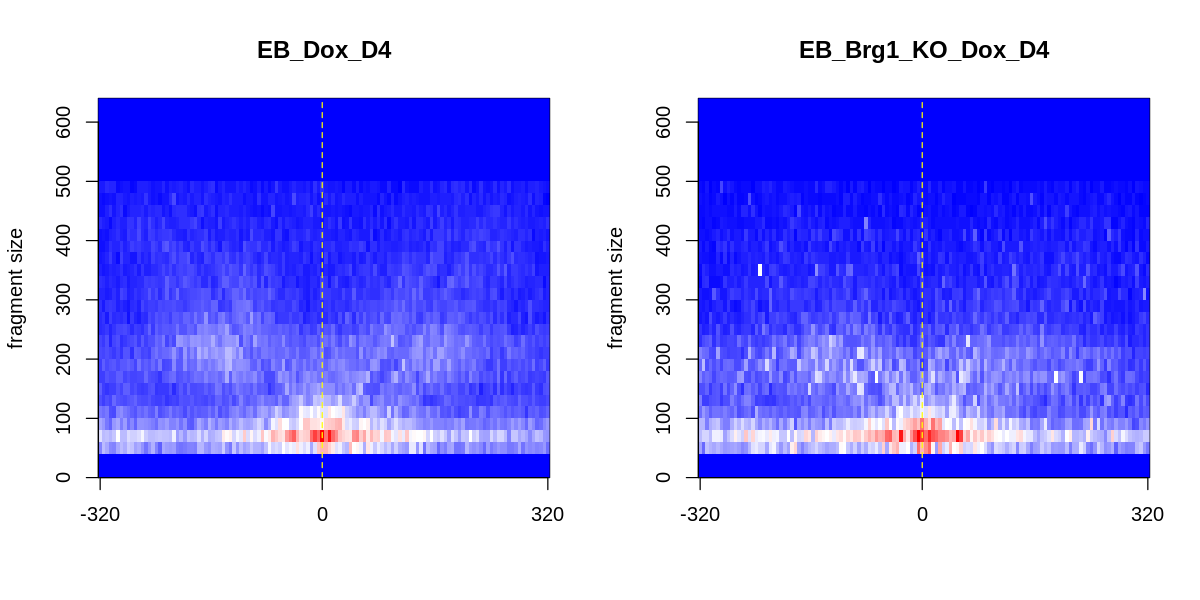

In [95]:
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
for (h in x@samples){
  i <- rowData(xm)$batch == h
  vplot(xm[i], 'counts', main = h)
}

## SessionInfo

In [96]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] chromVARmotifs_0.2.0               motifmatchr_1.14.0                
 [3] dplyr_1.0.7                        BSgenome.Mmusculus.UCSC.mm10_1.4.0
 [5] BSgenome_1.60.0                    rtracklayer_1.52.1                
 [7] Biostrings_2.60.

In [97]:
Sys.time() - start_time

Time difference of 1.05317 hours